In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
# import string
# from string import punctuation
# from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.utils import shuffle
# from sklearn import svm

# nltk.download('stopwords')
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

import re
import string

! pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

! pip install tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
import io
import json

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading dataset and exploration

In [2]:
df = pd.read_csv('AmazonReviews.csv')

In [3]:
df.columns

Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote'],
      dtype='object')

In [4]:
df.shape

(551159, 14)

In [5]:
print(df.isnull().sum())

userName         133
verified           0
itemName           1
description        8
image              0
brand           3872
feature            0
category           0
price          74334
rating             0
reviewTime         0
summary          243
reviewText       428
vote               0
dtype: int64


In [7]:
df.head(2)

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0


In [8]:
pos = df[df['rating']>3]
neg = df[df['rating']<3]
print(pos.shape, neg.shape)

(453086, 14) (57434, 14)


# Largely imbalanced
May have to oversample/undersample

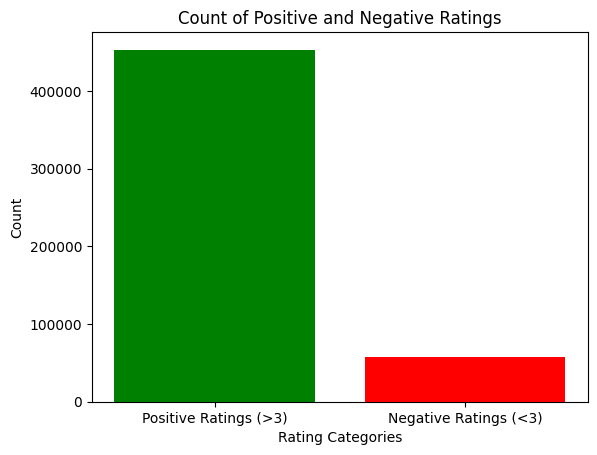

In [9]:
counts = [pos.shape[0], neg.shape[0]]

# Create a bar chart
plt.bar(['Positive Ratings (>3)', 'Negative Ratings (<3)'], counts, color=['green', 'red'])
plt.title('Count of Positive and Negative Ratings')
plt.ylabel('Count')
plt.xlabel('Rating Categories')
plt.show()

In [10]:
size = df.shape[0]
test_size = int(0.1*size)
training_size = size - test_size
int(test_size) + int(training_size) == size

True

## Adding sentiment values:
- Done via a sentiment map
- resulting column added to original dataframe

In [11]:
testing_set = df[:test_size]
training_set = df[test_size:]

In [14]:
sentiment_map = {1:0, 2:0, 4:1, 5:1}

temp = training_set[training_set['rating'] != 3]
y = training_set['rating'].map(sentiment_map)

training_set.loc[:, 'sentiment'] = y

In [15]:
training_set.head(2)

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote,sentiment
55115,B-RYE,True,MidWest Homes for Pets Dog Crate Cover,"['This is a lightweight, black polyester dog k...",['https://images-na.ssl-images-amazon.com/imag...,MidWest Homes for Pets,"[""Dog crate cover provides the privacy, securi...",Pet_Supplies,$10.18,3.0,2018-01-17,NIce but not for my dog.,It is nice but did not work for my dog. He wan...,0,NaN
55116,KnitWrite,True,MidWest Homes for Pets Dog Crate Cover,"['This is a lightweight, black polyester dog k...",['https://images-na.ssl-images-amazon.com/imag...,MidWest Homes for Pets,"[""Dog crate cover provides the privacy, securi...",Pet_Supplies,$10.18,5.0,2018-01-17,Great for Travel,"I had to take a trip with my dog, and purchase...",0,1.0


## Preparing dataframe for preprocessing

In [52]:
reviews_to_clean = pd.DataFrame()
reviews_to_clean = training_set['reviewText']

In [53]:
print(reviews_to_clean.head(3))

55115    It is nice but did not work for my dog. He wan...
55116    I had to take a trip with my dog, and purchase...
55117    The case seems to be well made and it fits the...
Name: reviewText, dtype: object


In [54]:
print(type(reviews_to_clean))

<class 'pandas.core.series.Series'>


In [55]:
print(reviews_to_clean.shape)

(496044,)


In [56]:
stop_words = stopwords.words('english')

## Cleaning HTML aspects
- includes tags and https:// 

In [57]:
def clean_html(text):
    # Remove URLs
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    return text

## Creating tokens

In [58]:
def tokenize_df(text):
    if isinstance(text, str):  # If the input is a string
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token.isalpha()]  # Keep only alphabetic tokens
        return tokens
    elif isinstance(text, (int, float)):  # If the input is an integer or float
        return text  # Return the number as is
    else:
        return []

## Removing stopwords

In [59]:
def remove_stopwords(tokens):
    stop_words = (stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

## Lemmatization:
- Spelling or semantics of words may have been affected via tokenisation or punctuation removal. This was done to try to preserve value of those that may have been affected

In [60]:
# def lemmatize_text(tokens):
#     lemma = WordNetLemmatizer()
#     lemma_token = [lemma.lemmatize(word) for word in tokens]
#     return lemma_token

def lemmatize_text(tokens):
    if tokens is None:
        return []  # Return an empty list if tokens is None
    lemma = WordNetLemmatizer()
    lemma_tokens = [lemma.lemmatize(word) for word in tokens if word is not None]  # Check for None
    return lemma_tokens

## Cleaning text utilizing prior functions

In [61]:
def clean_text(text):
    if not isinstance(text, str):  # Check if the input is not a string
        return ''  # Return an empty string or handle it as needed
    text = clean_html(text)
    tokens = tokenize_df(text)
    tokens = [token.lower() for token in tokens]
    tokens = remove_stopwords(tokens)
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
    tokens = lemmatize_text(tokens)
    return ' '.join(tokens)

In [62]:
cleaned_reviews = reviews_to_clean.apply(clean_text)

## Convert all instances of float or integer data to string:
- This was done to avoid instances of float or integer.
- Chose not to drop the values since it may hold value in our analysis

In [63]:
cleaned_reviews.apply(lambda x: re.sub(r"\s+", " ", x).strip()if isinstance(x, str) else x)

55115                          nice work dog wanted nothing
55116     take trip dog purchased use instead old blanke...
55117     case seems well made fit phone nicely problem ...
55118                                               durable
55119     skeptical dog would play love hide squirrel bu...
                                ...                        
551154                               cheap price weak chain
551155                                       great deck box
551156    putting weather station anticipate problem kee...
551157    nice quality grilling table put grilling stuff...
551158                       nice variety pack whole family
Name: reviewText, Length: 496044, dtype: object

## Dropping values:
- This was done to account for any rows that had no data. Avoids NaN representation for text_fit

In [64]:
cleaned_reviews = cleaned_reviews.fillna('').astype(str)

In [65]:
print(cleaned_reviews.isnull().sum())

0


In [66]:
cleaned_reviews.head(3)

55115                         nice work dog wanted nothing
55116    take trip dog purchased use instead old blanke...
55117    case seems well made fit phone nicely problem ...
Name: reviewText, dtype: object

In [67]:
def print_cloud(data):
    text = " ".join(review for review in data)
    print ("There are {} words in the combination of all reviews.".format(len(text)))
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(text)
    return wordcloud

## Visualisation
- Small visualisation to check if cleaning went as expected

There are 48448693 words in the combination of all reviews.


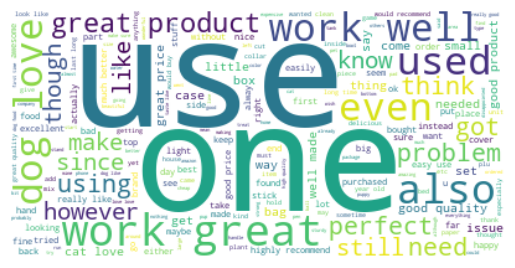

In [68]:
wordcloud = print_cloud(cleaned_reviews)
fig = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [69]:
X = cleaned_reviews
print(type(X))
print(X.shape)

<class 'pandas.core.series.Series'>
(496044,)


In [72]:
y = training_set['sentiment']
print(type(y))
print(y.shape)
print(y.isnull().sum()) 

<class 'pandas.core.series.Series'>
(496044,)
36577


## Dropping NaN 
- Dropped those rows with NaN representations in sentiments based on the assumption their rating was a 3/5. Justified since the data loss is negligible when compared to that which remains

In [73]:
y = y.dropna()
X = X[y.index] 
print(X.shape)
print(y.shape)

(459467,)
(459467,)


In [74]:
def text_fit(X, y, model, clf_model, coef_show=1):
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test,y_pred)
    print ('Model Recall: {}'.format(recall))
    if coef_show == 1: 
        w = model.get_feature_names_out()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))

## Interpretation
- A recall of approximately 0.99 indicates that the model is very effective at identifying positive sentiments in the reviews.
- The output lists the top 20 words (or n-grams) that are most strongly associated with positive sentiment, along with their coefficients.
- The words listed here are the strongest indicators of positive sentiment in the reviews. The coefficients represent the weight of each word in the logistic regression model.

In [75]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 2094230
# train records: 344600
# test records: 114867
Model Recall: 0.9916828062172498

-Top 20 positive-
            Word  Coefficient
            love    20.834726
           great    17.604871
         perfect    13.099046
            nice    10.985691
            best    10.957201
       excellent    10.085342
       delicious     9.575685
       perfectly     8.888323
            easy     8.773595
         amazing     8.525620
         awesome     8.103425
        favorite     8.005895
       complaint     6.848199
          easier     6.821953
       wonderful     6.650832
       fantastic     6.222455
highly recommend     6.130542
         pleased     6.017878
          highly     5.915957
          little     5.776716

-Top 20 negative-
         Word  Coefficient
unfortunately    -6.741721
      garbage    -6.820078
    worthless    -6.888681
       refund    -7.027667
        waste    -7.084596
      cheaply    -7.097450
        worse    -7.208695
  waste money   

## Usage of select percentile
- f_classif for classification tasks (ANOVA F-value between label/feature)
- Selecting only the most relevant features, it significantly reduces the dimensionality.
- Reduces overfitting, as the model will focus on the most informative features.
- Eliminating features that do not contribute significantly to the prediction, reduces the noise in the dataset; leads to better generalization on unseen data.

In [ ]:
def text_fit_v2(X, y, model, clf_model, select_percentile_value, coef_show=1):
    X_c = model.fit_transform(X)
    print('# features before applying select percentile: {}'.format(X_c.shape[1]))
    select_percentile = SelectPercentile(score_func=f_classif, percentile=select_percentile_value)
    X_transformed = select_percentile.fit_transform(X_c, y)
    print('# features after applying select percentile: {}'.format(X_transformed.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test,y_pred)
    print ('Model Recall: {}'.format(recall))
    if coef_show == 1:
        idx = np.arange(0, X_c.shape[1])  #create an index array
        features_to_keep = idx[select_percentile.get_support() == True]
        cols = np.array(list(model.vocabulary_.keys()))
        w = cols[features_to_keep]
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1, 2), stop_words = 'english')
text_fit_v2(X, y, tfidf_n, LogisticRegression(), 25, 1)

In [79]:
y.head(3)

55116    1.0
55117    0.0
55118    1.0
Name: sentiment, dtype: float64

In [80]:
reviews = []
sentiments = []

reviews = X
sentiments = y
sentiments = np.array(list(map(lambda x: 1 if x==1 else 0, sentiments)))

In [81]:
print(sentiments)

[1 0 1 ... 1 1 1]


In [82]:
len(reviews), len(sentiments)

(459467, 459467)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(reviews, sentiments, 
                                                test_size=0.20, random_state=42)

In [84]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [85]:
tokenizer_json = word_tokenizer.to_json()
with io.open('embedded.json', 'w', encoding = 'utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [86]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

57481

In [87]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [89]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [90]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [91]:
embedding_matrix.shape

(57481, 100)

In [92]:
from keras.layers import LSTM

In [93]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], 
                    input_length=100, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

c:\Users\kaila\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [94]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=['acc'])

In [97]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=7, 
                                        verbose=1,validation_split=0.2)

Epoch 1/7
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 256s 111ms/step - acc: 0.9528 - loss: 0.1265 - val_acc: 0.9405 - val_loss: 0.1566
Epoch 2/7
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 263s 114ms/step - acc: 0.9575 - loss: 0.1158 - val_acc: 0.9418 - val_loss: 0.1600
Epoch 3/7
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 264s 115ms/step - acc: 0.9620 - loss: 0.1061 - val_acc: 0.9410 - val_loss: 0.1664
Epoch 4/7
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 261s 114ms/step - acc: 0.9664 - loss: 0.0959 - val_acc: 0.9414 - val_loss: 0.1641
Epoch 5/7
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 288s 125ms/step - acc: 0.9710 - loss: 0.0852 - val_acc: 0.9351 - val_loss: 0.1859
Epoch 6/7
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 267s 116ms/step - acc: 0.9664 - loss: 0.0988 - val_acc: 0.9408 - val_loss: 0.1818
Epoch 7/7
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 258s 112ms/step - acc: 0.9570 - loss: 0.1178 - val_acc: 0.9000 - val_loss: 0.2413


In [98]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

2872/2872 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - acc: 0.9021 - loss: 0.2388


In [99]:
lstm_model.save(f"lstm_model.h5", save_format='h5')

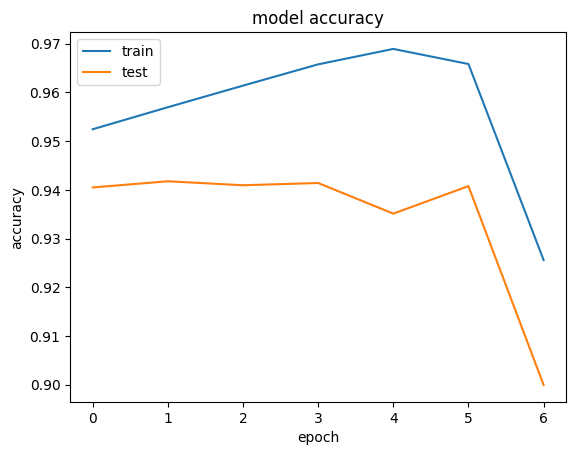

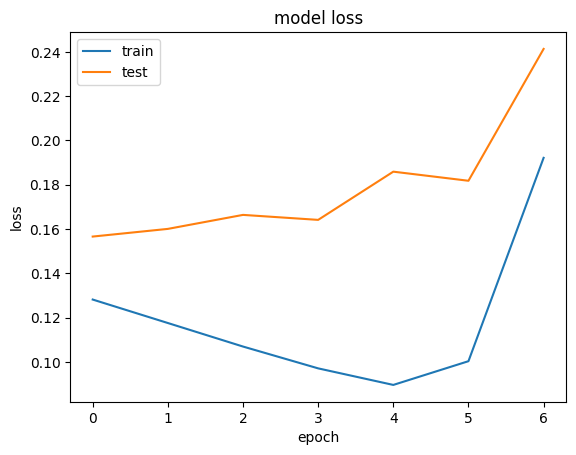

In [100]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [102]:
from keras.models import load_model

model_path = 'lstm_model.h5'
pretrained_lstm_model = load_model(model_path)
pretrained_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     5,748,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,865,479 (22.38 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 5,748,100 (21.93 MB)

 Optimizer params: 2 (12.00 B)

In [103]:
testing_set.head(2)

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0


In [112]:
unseen_reviews = testing_set['reviewText']
unseen_cleaned = unseen_reviews.apply(clean_text)

In [113]:
with open('embedded.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [114]:
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_cleaned)
unseen_tokenized

[[153, 328, 509, 1184, 65],
 [24, 5459],
 [407,
  318,
  28,
  139,
  15,
  40,
  318,
  28,
  359,
  2033,
  915,
  1693,
  541,
  1420,
  385,
  318,
  133,
  81,
  399,
  22,
  764,
  318,
  407,
  2207,
  36,
  151,
  95,
  105,
  26,
  114,
  261,
  1133,
  133,
  573,
  105,
  81,
  1006],
 [2,
  27,
  38663,
  6854,
  2204,
  112,
  117,
  1041,
  329,
  7692,
  9392,
  9699,
  10862,
  1041,
  329,
  5913,
  612,
  67,
  1106,
  11,
  8,
  155,
  26,
  323,
  137,
  158,
  4320,
  1261,
  5,
  23,
  612,
  67,
  981,
  3423,
  23,
  3824,
  336,
  157,
  413,
  123,
  123,
  942,
  111,
  12,
  96,
  9,
  3824,
  38663,
  335,
  9,
  1572,
  986,
  1572,
  742,
  153,
  1314,
  21,
  366,
  328,
  1992,
  366,
  23516],
 [2, 115, 2, 541, 102, 261, 51, 160, 62, 115],
 [1945, 120, 308, 1291, 4030, 8, 407, 935, 6, 29, 491, 6, 1608, 6711],
 [30, 75, 1804, 2, 284, 84, 29, 281, 526, 273],
 [4,
  8,
  1314,
  120,
  19373,
  1098,
  1006,
  81,
  811,
  6382,
  4,
  8629,
  4637,
  47

In [116]:
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)
unseen_padded

array([[ 153,  328,  509, ...,    0,    0,    0],
       [  24, 5459,    0, ...,    0,    0,    0],
       [ 407,  318,   28, ...,    0,    0,    0],
       ...,
       [ 288,    0,    0, ...,    0,    0,    0],
       [1317,  170,  139, ...,    0,    0,    0],
       [  24,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [117]:
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)
unseen_sentiments

1723/1723 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step


array([[0.9954537 ],
       [0.9860455 ],
       [0.9891384 ],
       ...,
       [0.98829687],
       [0.87463397],
       [0.9869559 ]], dtype=float32)

In [120]:
testing_set.head(1)

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0


In [138]:
# testing_set["predictedSentiment"] = np.round(unseen_sentiments*10, 1)
testing_set["predictedRating"] = np.round(unseen_sentiments * 5, 1)

df_prediction_sentiments = pd.DataFrame(testing_set['predictedRating'], columns = ['predictedRating'])
df_userName = pd.DataFrame(testing_set["userName"], columns=["userName"])
df_itemName = pd.DataFrame(testing_set["itemName"], columns=["itemName"])
df_brand = pd.DataFrame(testing_set["brand"], columns=["brand"])
df_category = pd.DataFrame(testing_set["category"], columns=["category"])
df_price = pd.DataFrame(testing_set["price"], columns=["price"])
df_rating = pd.DataFrame(testing_set["rating"], columns=["rating"])

dfx = pd.concat([df_userName, df_itemName, 
                 df_brand, df_category, df_price, 
                 df_rating, df_prediction_sentiments], axis=1)

dfx.head(2)

C:\Users\kaila\AppData\Local\Temp\ipykernel_24140\25855431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set["predictedRating"] = np.round(unseen_sentiments * 5, 1)


,userName,itemName,brand,category,price,rating,predictedRating
0,Amazon Customer,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...",Toblerone,Prime_Pantry,$1.63,5.0,5.0
1,Carla,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags",Prince Of Peace,Grocery_and_Gourmet_Food,$6.40,5.0,4.9


In [139]:
dfx.to_csv('predicted_sentiments.csv')